# Install pytorch lightning

In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 796 kB 4.0 MB/s 
     |████████████████████████████████| 136 kB 85.0 MB/s 
     |████████████████████████████████| 529 kB 66.6 MB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=489090cf964c734c66e2cfe75c99bd55690bf87d7bdce65cbba357cee39ee36d
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


# Import libraries we are going to use

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import Transformer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from nltk.tokenize import wordpunct_tokenize
from torchmetrics import BLEUScore
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import math
import random

# Download English-Spanish dataset

In [3]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

--2022-11-05 16:43:14--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.02s   

2022-11-05 16:43:14 (149 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [4]:
!unzip spa-eng.zip

Archive:  spa-eng.zip
   creating: spa-eng/
  inflating: spa-eng/_about.txt      
  inflating: spa-eng/spa.txt         


In [5]:
!ls ./spa-eng/

_about.txt  spa.txt


In [6]:
!head ./spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


# Prepare dataset for Neural Machine Translation

In [7]:
PAD_TOKEN = "<PAD>" # 0
START_TOKEN = "<START>" # 1
END_TOKEN = "<END>" # 2
UNK_TOKEN = "<UNK>" # 3

PAD_IDX = 0
START_IDX = 1
END_IDX = 2
UNK_IDX = 3

class CorpusDataset(Dataset):
    
  def __init__(self, src_sentences, dst_sentences, src_token2id=None, src_id2token=None, dst_token2id=None, dst_id2token=None,
               frequency_threshold=5):
    
    self.src_sentences = self._preprocess_sentences(src_sentences)
    self.dst_sentences = self._preprocess_sentences(dst_sentences)
    assert len(self.src_sentences) == len(self.dst_sentences)
    
    if src_token2id is None and src_id2token is None and dst_token2id is None and dst_id2token is None:
      self.src_token2id, self.src_id2token = self._build_token2id(self.src_sentences, frequency_threshold)
      self.dst_token2id, self.dst_id2token = self._build_token2id(self.dst_sentences, frequency_threshold)
    else:
      self.src_token2id, self.src_id2token = src_token2id, src_id2token
      self.dst_token2id, self.dst_id2token = dst_token2id, dst_id2token
    
  def _preprocess_sentences(self, sentences):
    sentences = [wordpunct_tokenize(s.lower()) for s in sentences]
    return sentences
    
  def _build_token2id(self, sentences, frequency_threshold):
      
    token2count = dict()
    for sentence in sentences:
      for token in sentence:
        token2count[token] = token2count.get(token, 0) + 1
    pairs = list(token2count.items())
    pairs.sort(key=lambda p:p[1], reverse=True)
    id2token = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN]
    id2token.extend(p[0] for p in pairs if p[1] >= frequency_threshold)
    token2id = { token:_id for _id, token in enumerate(id2token) }

    return token2id, id2token

  def _tokens2ids(self, token2id, tokens, is_target=False):
    ids = []
    if is_target:
      ids.append(token2id[START_TOKEN])
    for token in tokens:
      if token in token2id:
        ids.append(token2id[token])
      else:
        ids.append(token2id[UNK_TOKEN])
    if is_target:
      ids.append(token2id[END_TOKEN])
    return ids
    
  def __getitem__(self, idx):
    src_tokens, dst_tokens = self.src_sentences[idx], self.dst_sentences[idx]
    src_ids, dst_ids = self._tokens2ids(self.src_token2id, src_tokens), self._tokens2ids(self.dst_token2id, dst_tokens, is_target=True)
    return {
        "idx": idx,
        "src": src_ids,
        "dst": dst_ids
    }
    
  def __len__(self):
    return len(self.src_sentences)
    
  def src_ids2string(self, ids):
    tokens = []
    for id in ids:
      if id == END_IDX: # END_TOKEN
        break
      if id >= 3:
        tokens.append(self.src_id2token[id])
    return " ".join(tokens)

  def dst_ids2string(self, ids):
    tokens = []
    for id in ids:
      if id == END_IDX: # END_TOKEN
        break
      if id >= 3:
        tokens.append(self.dst_id2token[id])
    return " ".join(tokens)

In [8]:
# Read spa.txt and collect english and spanish sentences
english_sentences = []
spanish_sentences = []
with open('./spa-eng/spa.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    a, b = line.split('\t')
    english_sentences.append(a.strip())
    spanish_sentences.append(b.strip())

In [9]:
len(english_sentences), len(spanish_sentences)

(118964, 118964)

In [10]:
corpus_dataset = CorpusDataset(src_sentences=english_sentences, dst_sentences=spanish_sentences, frequency_threshold=2)

In [11]:
print(f'Src vocab size: {len(corpus_dataset.src_id2token)}')
print(f'Dst vocab size: {len(corpus_dataset.dst_id2token)}')

Src vocab size: 8869
Dst vocab size: 15295


Split dataset into train, validation and test

In [12]:
train_size = int(len(corpus_dataset) * 0.95)
val_size = int(len(corpus_dataset) * 0.025)
test_size = len(corpus_dataset) - train_size - val_size

print(f'Train size: {train_size}')
print(f'Val size: {val_size}')
print(f'Test size: {test_size}')

Train size: 113015
Val size: 2974
Test size: 2975


In [13]:
train_dataset, val_dataset, test_dataset = random_split(corpus_dataset, [train_size, val_size, test_size])

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### Utility code for exponential warmup + decay of learning rate

In [15]:
from torch.optim.lr_scheduler import ExponentialLR, _LRScheduler
from bisect import bisect_right

class SequentialLR(_LRScheduler):
  def __init__(self, optimizer, schedulers, milestones, last_epoch=-1):
    for scheduler_idx in range(1, len(schedulers)):
      if (schedulers[scheduler_idx].optimizer != schedulers[0].optimizer):
        raise ValueError(
            "Sequential Schedulers expects all schedulers to belong to the same optimizer, but "
            "got schedulers at index {} and {} to be different".format(0, scheduler_idx)
        )
    if (len(milestones) != len(schedulers) - 1):
      raise ValueError(
          "Sequential Schedulers expects number of schedulers provided to be one more "
          "than the number of milestone points, but got number of schedulers {} and the "
          "number of milestones to be equal to {}".format(len(schedulers), len(milestones))
      )
    self.optimizer = optimizer
    self._schedulers = schedulers
    self._milestones = milestones
    self.last_epoch = last_epoch + 1

  def step(self):
    self.last_epoch += 1
    idx = bisect_right(self._milestones, self.last_epoch)
    self._schedulers[idx].step()

  def state_dict(self):
    state_dict = {key: value for key, value in self.__dict__.items() if key not in ('optimizer', '_schedulers')}
    state_dict['_schedulers'] = [None] * len(self._schedulers)

    for idx, s in enumerate(self._schedulers):
      state_dict['_schedulers'][idx] = s.state_dict()

    return state_dict

  def load_state_dict(self, state_dict):
    _schedulers = state_dict.pop('_schedulers')
    self.__dict__.update(state_dict)
    state_dict['_schedulers'] = _schedulers

    for idx, s in enumerate(_schedulers):
      self._schedulers[idx].load_state_dict(s)

def calc_gamma(lr_a, lr_b, steps):
  return (lr_b / lr_a) ** (1/steps)

def parse_warmup_and_decay_args_string(string):
  args = string.split(',')
  assert len(args) == 5
  return float(args[0]), int(args[1]), float(args[2]), int(args[3]), float(args[4])

def create_warmup_and_decay_lr_scheduler(optimizer, warmup_and_decay_args):
  lr0, steps01, lr1, steps12, lr2 = parse_warmup_and_decay_args_string(warmup_and_decay_args)
  scheduler1 = ExponentialLR(optimizer, gamma=calc_gamma(lr0, lr1, steps01), verbose=False)
  scheduler2 = ExponentialLR(optimizer, gamma=calc_gamma(lr1, lr2, steps12), verbose=False)
  scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[steps01+1])
  return scheduler

 # Code for Transformer-based Neural Machine Translation

![picture](https://drive.google.com/uc?id=17OvbggPMTQrarOYpVThyzN3txz_DDEhJ)

Source: *Attention Is All You Need* (https://arxiv.org/pdf/1706.03762.pdf)

In [16]:
# Most of the code is based on https://pytorch.org/tutorials/beginner/translation_transformer.html

def generate_square_subsequent_mask(sz):
  mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
  return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
  def __init__(self,
              emb_size,
              dropout,
              maxlen = 5000):
    super(PositionalEncoding, self).__init__()
    den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    pos_embedding = torch.zeros((maxlen, emb_size))
    pos_embedding[:, 0::2] = torch.sin(pos * den)
    pos_embedding[:, 1::2] = torch.cos(pos * den)
    pos_embedding = pos_embedding.unsqueeze(-2)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('pos_embedding', pos_embedding)

  def forward(self, token_embedding):
      return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
  def __init__(self, vocab_size: int, emb_size):
      super(TokenEmbedding, self).__init__()
      self.embedding = nn.Embedding(vocab_size, emb_size)
      self.emb_size = emb_size

  def forward(self, tokens):
      return self.embedding(tokens.long()) # * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
  def __init__(self,
              num_encoder_layers,
              num_decoder_layers,
              emb_size,
              nhead,
              src_vocab_size,
              tgt_vocab_size,
              dim_feedforward = 512,
              dropout = 0.1):
    super(Seq2SeqTransformer, self).__init__()
    self.transformer = Transformer(d_model=emb_size,
                                  nhead=nhead,
                                  num_encoder_layers=num_encoder_layers,
                                  num_decoder_layers=num_decoder_layers,
                                  dim_feedforward=dim_feedforward,
                                  dropout=dropout)
    self.generator = nn.Linear(emb_size, tgt_vocab_size)
    self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
    self.positional_encoding = PositionalEncoding(
        emb_size, dropout=dropout)
    self.register_buffer('start_idx', torch.tensor(START_IDX))

  def forward(self,
              src,
              trg,
              src_mask,
              tgt_mask,
              src_padding_mask,
              tgt_padding_mask,
              memory_key_padding_mask):
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
    outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                            src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
    return self.generator(outs)

  def encode(self, src, src_mask):
    return self.transformer.encoder(self.positional_encoding(
                        self.src_tok_emb(src)), src_mask)

  def decode(self, tgt, memory, tgt_mask):
    return self.transformer.decoder(self.positional_encoding(
                      self.tgt_tok_emb(tgt)), memory,
                      tgt_mask)
  
  def greedy_decode(self, src, src_mask, max_len, start_symbol):
    memory = self.encode(src, src_mask)
    ys = torch.ones(1, src.size(1)).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
      tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                  .type(torch.bool)).to(DEVICE)
      out = self.decode(ys, memory, tgt_mask)
      vocab_logits = self.generator(out[-1])
      next_tokens = vocab_logits.argmax(-1)
      next_tokens = next_tokens.unsqueeze(0)
      ys = torch.cat([ys, next_tokens], dim=0)
    return ys
    
class Transformer_NeuralMachineTranslator(pl.LightningModule):

  def __init__(
    self,
    src_vocab_size,
    tgt_vocab_size,
    num_encoder_layers,
    num_decoder_layers,
    emb_size,
    nhead,
    ffn_hid_dim,    
    dst_ids2string,
    dropout=0,
    initial_lr=1e-6,
    warmup_and_decay_lr_args="1e-6,4,5e-4,120,1e-6",
  ):
    super().__init__()

    self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    self.transformer = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size,
                                 nhead, src_vocab_size, tgt_vocab_size, ffn_hid_dim, dropout=dropout)
    
    self.dst_ids2string = dst_ids2string
    self.initial_lr = initial_lr
    self.warmup_and_decay_lr_args = warmup_and_decay_lr_args
    
    self.train_gt_sentences = []
    self.train_gen_sentences = []
    self.val_gt_sentences = []
    self.val_gen_sentences = []
    self.test_gt_sentences = []
    self.test_gen_sentences = []
    self.test_idxs = []

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.initial_lr)
    scheduler = create_warmup_and_decay_lr_scheduler(optimizer, self.warmup_and_decay_lr_args)
    return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

  def training_step(self, train_batch, batch_idx):
    src, tgt = train_batch['src'], train_batch['dst']
    
    tgt_input = tgt[:-1, :]
    
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = self.transformer(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:, :]

    logits_ = logits.permute(1, 0, 2)
    tgt_out_ = tgt_out.permute(1, 0)

    # accumulate sentences
    gen_sentences = logits_.argmax(-1)
    for i in range(gen_sentences.size(0)):
      self.train_gen_sentences.append(self.dst_ids2string(gen_sentences[i]))
      self.train_gt_sentences.append([self.dst_ids2string(tgt_out_[i])])

    # loss    
    loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    self.log('train_loss', loss, on_step=False, on_epoch=True, batch_size=src.size(1))

    return loss

  def validation_step(self, val_batch, batch_idx):
    src, tgt = val_batch['src'], val_batch['dst']
    
    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = self.transformer(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:, :]

    logits_ = logits.permute(1, 0, 2)
    tgt_out_ = tgt_out.permute(1, 0)

    # accumulate sentences
    gen_sentences = logits_.argmax(-1)
    for i in range(gen_sentences.size(0)):
      self.val_gen_sentences.append(self.dst_ids2string(gen_sentences[i]))
      self.val_gt_sentences.append([self.dst_ids2string(tgt_out_[i])])

    # loss
    loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=src.size(1))

  def test_step(self, test_batch, batch_idx):    

    src, tgt, idxs = test_batch['src'], test_batch['dst'], test_batch['idx']
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)    
    gen_sentences = self.transformer.greedy_decode(src, src_mask, max_len=tgt_seq_len, start_symbol=START_IDX)

    tgt_ = tgt.permute(1, 0)
    gen_sentences_ = gen_sentences.permute(1, 0)

    # accumulate sentences
    for i in range(gen_sentences.size(0)):
      self.test_gen_sentences.append(self.dst_ids2string(gen_sentences_[i]))
      self.test_gt_sentences.append([self.dst_ids2string(tgt_[i])])
      self.test_idxs.append(idxs[i].item())

  def on_train_epoch_start(self):
    self.train_gen_sentences.clear()
    self.train_gt_sentences.clear()

  def on_validation_epoch_start(self):
    self.val_gen_sentences.clear()
    self.val_gt_sentences.clear()
  
  def on_test_epoch_start(self):
    self.test_gen_sentences.clear()
    self.test_gt_sentences.clear()
    self.test_idxs.clear()
  
  def on_train_epoch_end(self):
    # Average of BLEU 1, 2, 3, 4
    bleu_score = sum(BLEUScore(n_gram=i)(self.train_gen_sentences, self.train_gt_sentences) for i in range(1, 5)) / 4
    self.log('train_bleu', bleu_score)
  
  def on_validation_epoch_end(self):
    # Average of BLEU 1, 2, 3, 4
    bleu_score = sum(BLEUScore(n_gram=i)(self.val_gen_sentences, self.val_gt_sentences) for i in range(1, 5)) / 4
    self.log('val_bleu', bleu_score)

  def on_test_epoch_end(self):
    for i in range(1, 5):
      bleu_score = BLEUScore(n_gram=i)
      self.log(f'test_bleu_{i}', bleu_score(self.test_gen_sentences, self.test_gt_sentences))

# Create dataloaders

In [17]:
class CyclicDataloaderWrapper:
  def __init__(self, loader, n_steps_per_epoch):
    self.n_steps_per_epoch = n_steps_per_epoch
    self.idx = 0
    self.loader = loader
    self.iter_loader = iter(loader)

  def __iter__(self):
    self.iter_loader = iter(self.loader)
    self.idx = 0
    return self

  def __len__(self):
    return self.n_steps_per_epoch

  def __next__(self):
    # if reached number of steps desired, stop
    if self.idx == self.n_steps_per_epoch:
        self.idx = 0
        raise StopIteration
    else:
        self.idx += 1
    # while True
    try:
        return next(self.iter_loader)
    except StopIteration:
        # reinstate iter_loader, then continue
        self.iter_loader = iter(self.loader)
        return next(self.iter_loader)

In [18]:
BATCH_SIZE = 256

In [19]:
def collate_fn(batch):
  indexes = list(range(len(batch)))
  batch_dict = {}
  batch_dict['idx'] = torch.tensor([batch[i]['idx'] for i in indexes])
  for elem in ('src', 'dst'):
    batch_dict[elem] = nn.utils.rnn.pad_sequence(
            sequences=[torch.tensor(batch[i][elem]) for i in indexes],
            padding_value=PAD_IDX)
  return batch_dict

In [20]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=6)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=6)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=6)

In [21]:
cyclic_train_dataloader = CyclicDataloaderWrapper(train_dataloader, n_steps_per_epoch=100)

# Create neural machine translator model

In [22]:
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0

In [23]:
model = Transformer_NeuralMachineTranslator(
    src_vocab_size=len(corpus_dataset.src_token2id),
    tgt_vocab_size=len(corpus_dataset.dst_token2id),
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    ffn_hid_dim=FFN_HID_DIM,
    dst_ids2string=corpus_dataset.dst_ids2string,
    dropout=DROPOUT,
    initial_lr=1e-6,
    warmup_and_decay_lr_args="1e-6,3,5e-4,60,1e-6",
)

# Train model

In [24]:
logger = pl.loggers.CSVLogger("logs", name="nmt-transformer-experiment", version='main')
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_bleu",
    mode="max",
    filename="nmt-{epoch:02d}-{val_bleu:.3f}",
    save_on_train_epoch_end=True,
)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=64,
                     logger=logger, callbacks=[checkpoint_callback, lr_monitor])
                    #  overfit_batches=0.05)
trainer.fit(model, cyclic_train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | loss_fn     | CrossEntropyLoss   | 0     
1 | transformer | Seq2SeqTransformer | 32.8 M
---------------------------------------------------
32.8 M    Trainable params
0         Non-trainable params
32.8 M    Total params
131.373   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=64` reached.


# Plot Train & Validation Curves

In [25]:
def plot_train_val_curves(logs_path, metric_names, single_plot_figsize=(8, 6)):

    logs = pd.read_csv(logs_path)
    assert len(logs) % 2 == 0
    
    n = len(metric_names)
    ncols = 2 if n > 1 else 1
    nrows = n // ncols + bool(n % ncols)

    figsize = (single_plot_figsize[0] * ncols, single_plot_figsize[1] * nrows)
    plt.figure(figsize=figsize)

    for j in range(n):

        metric_name = metric_names[j]
        train_scores = logs[f'train_{metric_name}'].dropna()
        val_scores = logs[f'val_{metric_name}'].dropna()
        assert len(train_scores) == len(val_scores)
        
        epochs = list(range(1, len(train_scores)+1))        
        
        eps = 0.9

        if metric_name == 'loss':
          agg_fn = min
        else:
          agg_fn = max
        
        ax = plt.subplot(nrows, ncols, j+1)
        ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
        ax.set_title(f'{metric_name} per epoch')
        ax.plot(epochs, train_scores, label=f'{metric_name} (Training)')
        ax.plot(epochs, val_scores, label=f'{metric_name} (Validation)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_name)    
        ax.legend()
        best_train_score, best_train_i = agg_fn((a,i) for i,a in enumerate(train_scores))
        ax.hlines(best_train_score, epochs[0], epochs[-1], colors=('green',), linestyles='dashed',
                label=f'best train {metric_name}={best_train_score:.3f}, epoch={best_train_i}')
        best_val_score, best_val_i = agg_fn((a,i) for i,a in enumerate(val_scores))
        ax.hlines(best_val_score, epochs[0], epochs[-1], colors=('red',), linestyles='dashed',
                label=f'best val {metric_name}={best_val_score:.3f}, epoch={best_val_i}')
        ax.legend()
    
    plt.show()

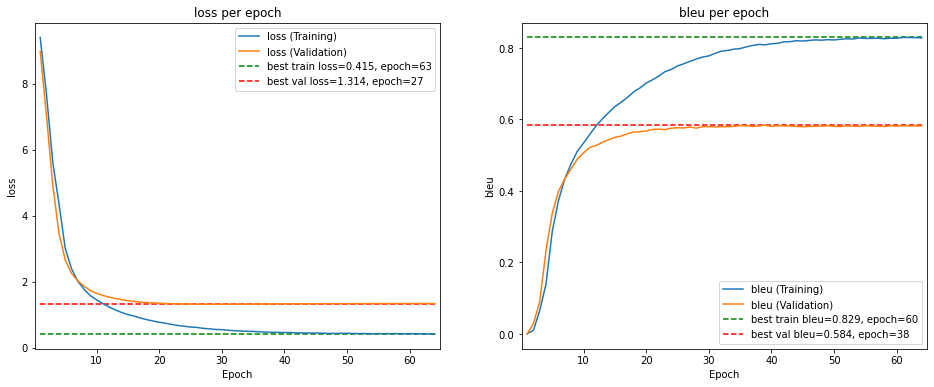

In [26]:
plot_train_val_curves('logs/nmt-transformer-experiment/main/metrics.csv', ['loss', 'bleu'])

# Evaluate on Test Split

In [27]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/nmt-transformer-experiment/main/checkpoints/nmt-epoch=38-val_bleu=0.584.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at logs/nmt-transformer-experiment/main/checkpoints/nmt-epoch=38-val_bleu=0.584.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1          0.29563742876052856
       test_bleu_2          0.21659114956855774
       test_bleu_3          0.16287153959274292
       test_bleu_4          0.1236327514052391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 0.29563742876052856,
  'test_bleu_2': 0.21659114956855774,
  'test_bleu_3': 0.16287153959274292,
  'test_bleu_4': 0.1236327514052391}]

# Inspect test set prediction examples

In [28]:
def process_test_predictions():
  bleu_score_1 = BLEUScore(n_gram=1)
  bleu_score_2 = BLEUScore(n_gram=2)
  bleu_score_3 = BLEUScore(n_gram=3)
  bleu_score_4 = BLEUScore(n_gram=4)
  n = len(model.test_gt_sentences)
  output = []
  for i in range(n):
    src = corpus_dataset.src_ids2string(corpus_dataset[model.test_idxs[i]]['src'])
    dst_gt = corpus_dataset.dst_ids2string(corpus_dataset[model.test_idxs[i]]['dst'])
    assert dst_gt == model.test_gt_sentences[i][0]
    dst_gen = model.test_gen_sentences[i]
    output.append({
        'src': src,
        'dst_gt': dst_gt,
        'dst_gen': dst_gen,
        'bleu_1': bleu_score_1([dst_gen], [[dst_gt]]).item(),
        'bleu_2': bleu_score_2([dst_gen], [[dst_gt]]).item(),
        'bleu_3': bleu_score_3([dst_gen], [[dst_gt]]).item(),
        'bleu_4': bleu_score_4([dst_gen], [[dst_gt]]).item(),
    })
  output.sort(key=lambda x : x['bleu_1']+x['bleu_2']+x['bleu_3']+x['bleu_4'], reverse=True)
  return output

In [29]:
test_predictions = process_test_predictions()

**Top 8 examples**

In [30]:
for i in range(8):
  pprint(test_predictions[i])
  print()

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'tom está escuchando música .',
 'dst_gt': 'tom está escuchando música .',
 'src': 'tom is listening to music .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'tom corrió tan rápido como pudo .',
 'dst_gt': 'tom corrió tan rápido como pudo .',
 'src': 'tom ran as fast as he could .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'tom y mary se odian .',
 'dst_gt': 'tom y mary se odian .',
 'src': 'tom and mary hate each other .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'hoy estoy en tokio .',
 'dst_gt': 'hoy estoy en tokio .',
 'src': 'i am in tokyo today .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'tuvieron un niño .',
 'dst_gt': 'tuvieron un niño .',
 'src': 'they had a boy .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'me encanta el queso 

**Worst 8 examples**

In [31]:
for i in range(1, 9):
  pprint(test_predictions[-i])
  print()

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'a que les va a llevar la ley con el camino de todas las se van a '
            '<UNK> a los <UNK> a <UNK> a los <UNK> a',
 'dst_gt': 'portar armas es ilegal .',
 'src': "it ' s against the law to carry weapons ."}

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'nos <UNK> con el camino de van a ponerte a su camino con van a '
            'van a van',
 'dst_gt': 'ganamos .',
 'src': 'we won .'}

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'si le pasa a tom , se le va a <UNK> a tom al fin de policía con '
            'el camino',
 'dst_gt': 'sentate tomás .',
 'src': 'sit down , tom .'}

{'bleu_1': 0.02857142500579357,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'a tom le <UNK> con el <UNK> de con el camino de todas a todo el '
            'camino con el fin de policía a todo el que le <UNK> a <UNK> a '
            'todo el <UNK> a',
 '

**10 random examples**

In [32]:
for i in random.sample(range(20, len(test_predictions) - 20), 10):
  pprint(test_predictions[i])
  print()

{'bleu_1': 0.5,
 'bleu_2': 0.267261266708374,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'tom no se puso luces la lluvia .',
 'dst_gt': 'tom no apagó las luces .',
 'src': "tom didn ' t turn off the lights ."}

{'bleu_1': 0.2222222089767456,
 'bleu_2': 0.11433238536119461,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'aquí hay algunos remedio para que se <UNK> a su camino de van a '
            'van a <UNK> a',
 'dst_gt': 'aquí hay algo de medicina para la diarrea .',
 'src': "here ' s some medicine for diarrhea ."}

{'bleu_1': 0.3636363744735718,
 'bleu_2': 0.19069251418113708,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'si fuera fuera <UNK> , sería un policía de manera .',
 'dst_gt': 'si volviera a nacer otra vez , sería músico .',
 'src': 'if i were to be born again , i would be a musician .'}

{'bleu_1': 0.08571428060531616,
 'bleu_2': 0.0502096489071846,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'me quedé profundamente del año de los años de con los <UNK> a los '
            '<

# References

- LANGUAGE TRANSLATION WITH NN.TRANSFORMER AND TORCHTEXT: https://pytorch.org/tutorials/beginner/translation_transformer.html
- VASWANI, Ashish, et al. Attention is all you need. Advances in neural information processing systems, 2017, vol. 30. (https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)